In [41]:
import sys

sys.path.append("../")

In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# import data.drawings.make_tasks as drawing_tasks
from src.analysis_utilities import SynthesisExperimentAnalyzer
from src.config_builder import ExperimentType

In [47]:
sns.set_theme(style="whitegrid", font_scale=1.25, rc={'figure.figsize':(12, 8)})

In [48]:
%config InlineBackend.figure_format = 'retina'

In [58]:
# EXPERIMENT_NAME = "runs_re2"
# DOMAIN = "re2"

# EXPERIMENT_NAME = "runs_clevr"
# DOMAIN = "clevr"

# EXPERIMENT_NAME = "runs_logo"
# DOMAIN = "logo"

EXPERIMENT_NAME = "runs_logo_1800"
DOMAIN = "logo"

COMPUTE_LIKELIHOODS = True

FIGURES_DIR = os.path.join("figures", EXPERIMENT_NAME)
FIGURES_DOMAIN_DIR = os.path.join("figures", EXPERIMENT_NAME, DOMAIN)
os.makedirs(FIGURES_DOMAIN_DIR, exist_ok=True)

In [59]:
analyzer = SynthesisExperimentAnalyzer(
    experiment_name=EXPERIMENT_NAME,
    experiment_types=["baseline_dreamcoder", "gpt_solver", "gpt_solver_stitch_namer", "gpt_solver_stitch_namer_hybrid_dsl", "gpt_solver_stitch_namer_search", "gpt_solver_stitch_namer_hybrid_dsl_2x2"],
    # experiment_types=["baseline_dreamcoder", "gpt_solver", "gpt_solver_stitch_namer", "gpt_solver_stitch_namer_search"],
    allow_incomplete_results=True,
    compute_likelihoods=COMPUTE_LIKELIHOODS,
    batch_size = 96,
    seeds = [111, 222, 333],
)

Experiment directory: ../experiments_iterative/outputs/runs_logo_1800
Available domains: ['logo']


## Runtime metrics

In [60]:
df_runtime = analyzer.get_runtime_metrics()
df_runtime

,curr_iteration,model_type,model_fn,task_split,time_start,time_end,time_elapsed,domain,experiment_type,seed,iteration
0,0,grammar,infer_programs_for_tasks,train,2023-05-05 20:42:54.619763968+00:00,2023-05-05 21:12:57.968629248+00:00,1803.348866,logo,baseline_dreamcoder,111,0
1,0,amortized_synthesis,optimize_model_for_frontiers,train,2023-05-05 21:12:57.970196480+00:00,2023-05-05 21:21:40.603402752+00:00,522.633206,logo,baseline_dreamcoder,111,0
2,0,amortized_synthesis,infer_programs_for_tasks,train,2023-05-05 21:21:40.604533248+00:00,2023-05-05 21:51:53.796587520+00:00,1813.192054,logo,baseline_dreamcoder,111,0
3,0,amortized_synthesis,infer_programs_for_tasks,test,2023-05-05 21:51:53.798867200+00:00,2023-05-05 22:42:01.095258368+00:00,3007.296391,logo,baseline_dreamcoder,111,0
4,1,amortized_synthesis,optimize_model_for_frontiers,train,2023-05-05 22:42:02.188915712+00:00,2023-05-05 22:54:41.303274240+00:00,759.114358,logo,baseline_dreamcoder,111,1
5,1,amortized_synthesis,infer_programs_for_tasks,train,2023-05-05 22:54:41.304280832+00:00,2023-05-05 23:24:55.255244032+00:00,1813.950963,logo,baseline_dreamcoder,111,1
6,2,amortized_synthesis,optimize_model_for_frontiers,train,2023-05-05 23:24:57.358040320+00:00,2023-05-05 23:37:13.811878144+00:00,736.453838,logo,baseline_dreamcoder,111,2
7,2,amortized_synthesis,infer_programs_for_tasks,train,2023-05-05 23:37:13.812904960+00:00,2023-05-06 00:07:38.319553280+00:00,1824.506648,logo,baseline_dreamcoder,111,2
8,3,amortized_synthesis,optimize_model_for_frontiers,train,2023-05-06 00:07:41.280408576+00:00,2023-05-06 00:21:24.155295744+00:00,822.874887,logo,baseline_dreamcoder,111,3
9,3,amortized_synthesis,infer_programs_for_tasks,train,2023-05-06 00:21:24.156562944+00:00,2023-05-06 00:51:48.295260416+00:00,1824.138697,logo,baseline_dreamcoder,111,3


In [61]:
df_runtime.query("experiment_type == 'gpt_solver_stitch_namer_hybrid_dsl'")

,curr_iteration,model_type,model_fn,task_split,time_start,time_end,time_elapsed,domain,experiment_type,seed,iteration


In [62]:
df_runtime.groupby(["domain", "experiment_type", "model_type", "model_fn", "task_split"]).time_elapsed.agg("mean")

domain  experiment_type      model_type           model_fn                      task_split
logo    baseline_dreamcoder  amortized_synthesis  infer_programs_for_tasks      test          2161.416951
                                                                                train         1822.926664
                                                  optimize_model_for_frontiers  train         1001.312105
                             grammar              infer_programs_for_tasks      train         1803.809732
Name: time_elapsed, dtype: float64

<AxesSubplot:xlabel='time_elapsed', ylabel='experiment_type'>

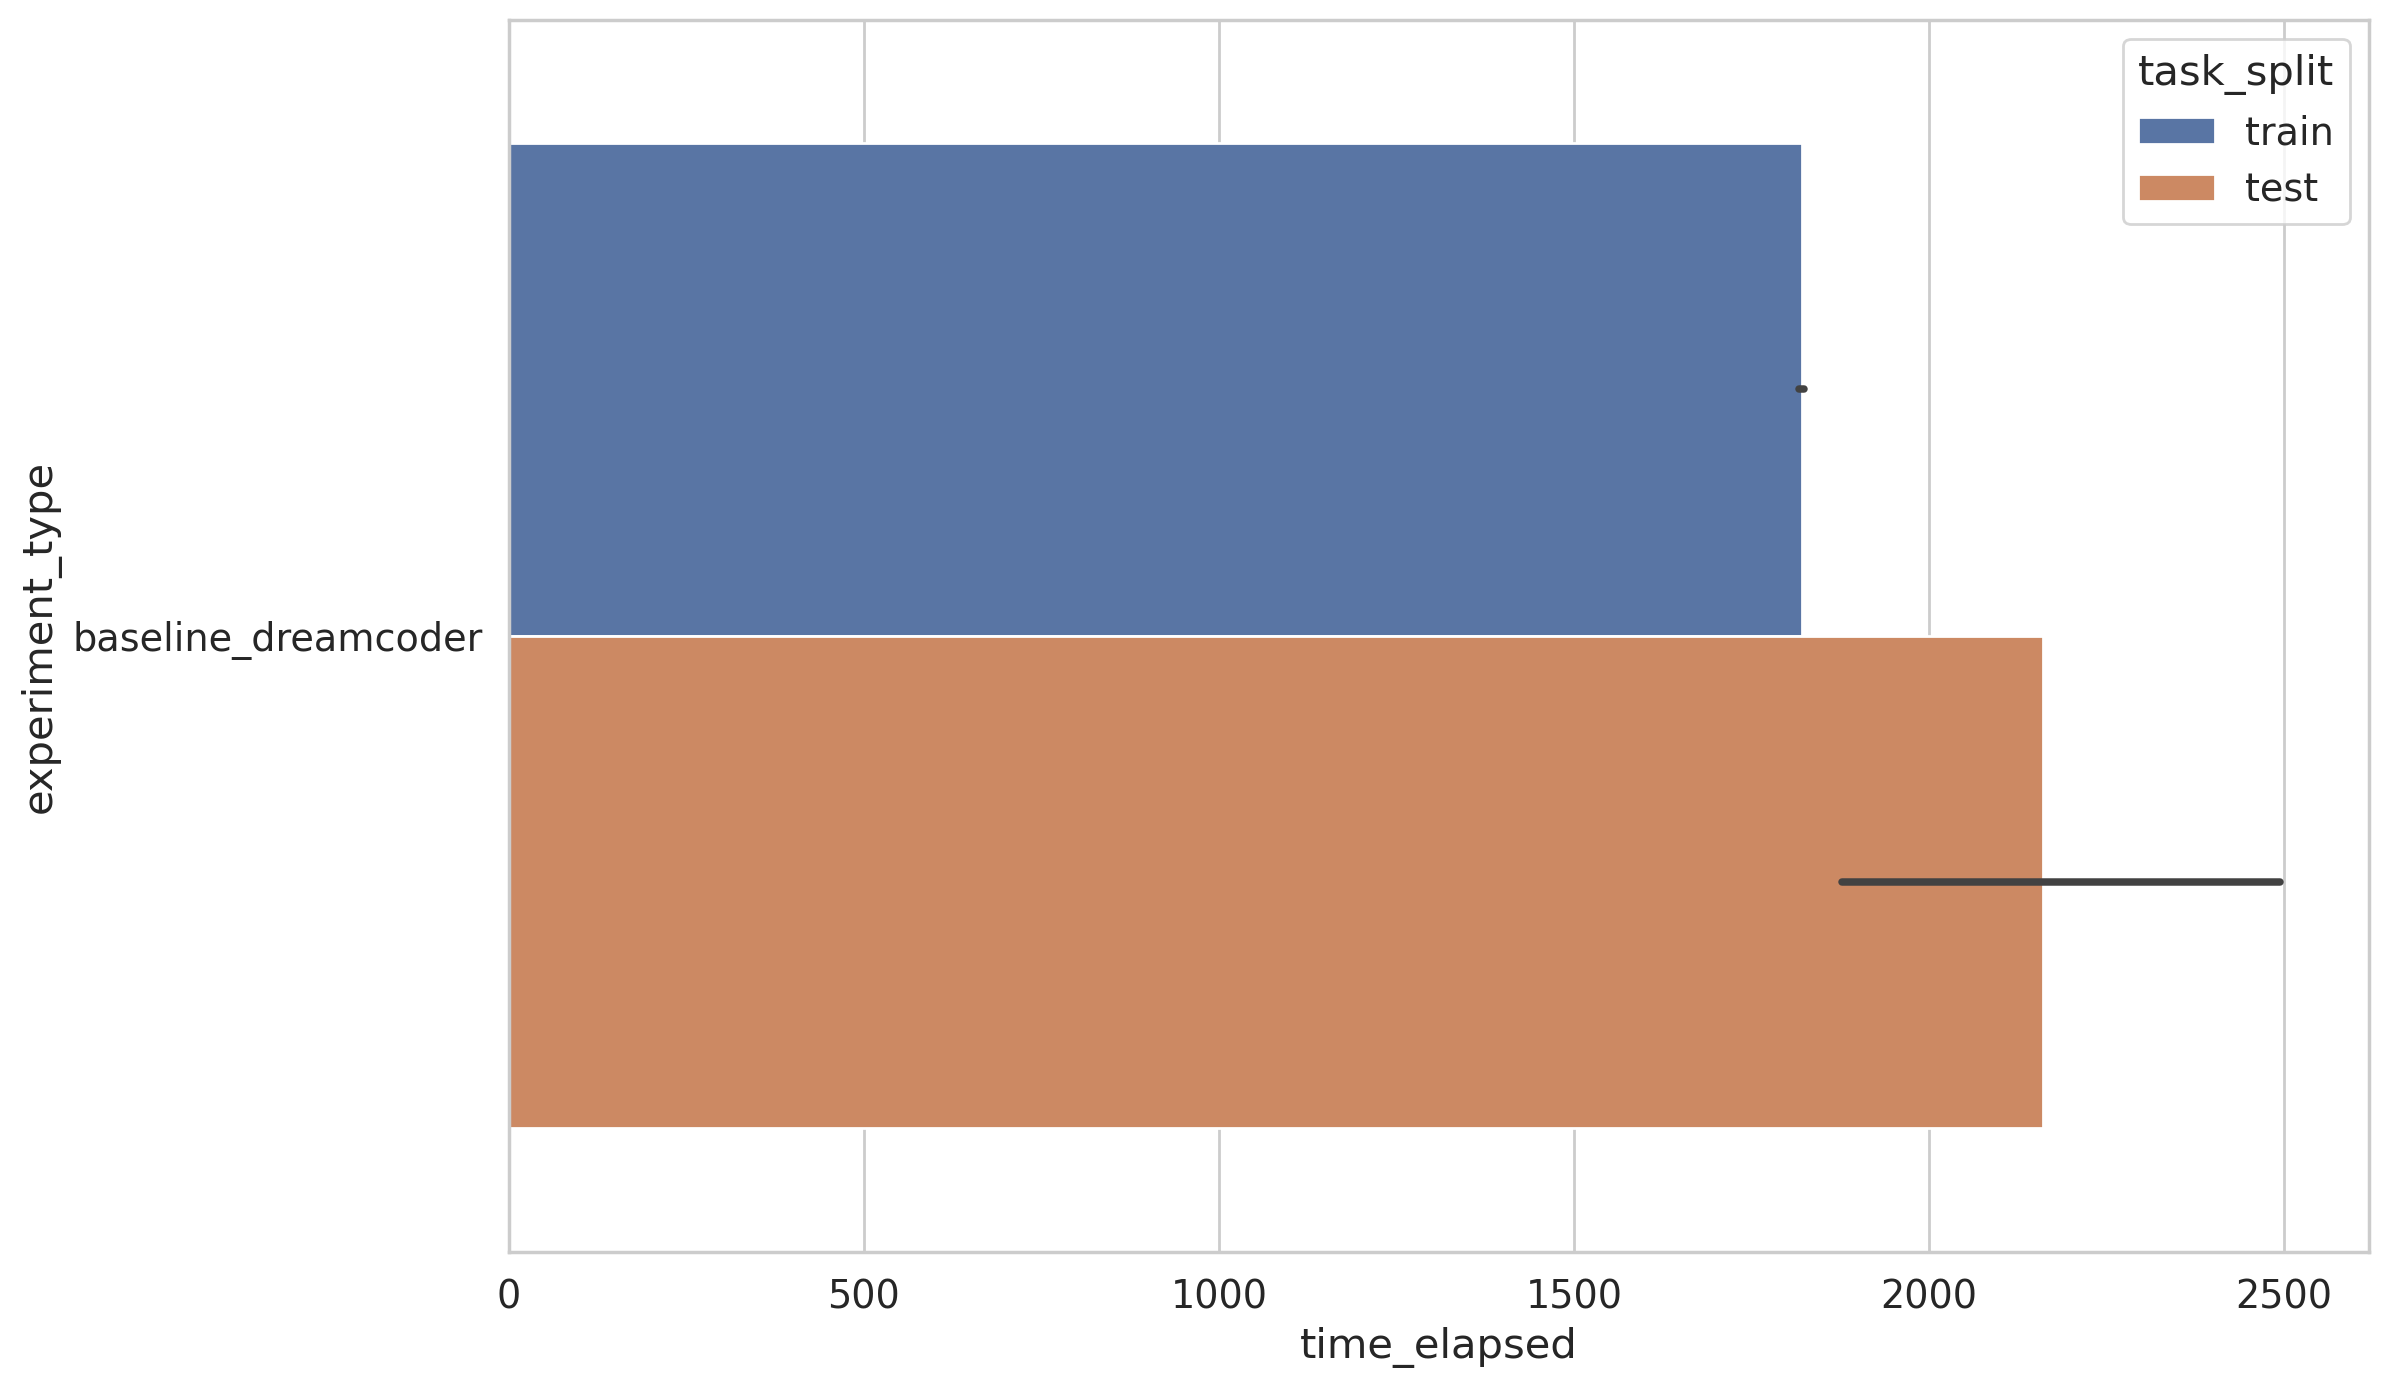

In [63]:
sns.barplot(data=df_runtime.query("model_fn == 'infer_programs_for_tasks'"), y="experiment_type", x="time_elapsed", hue="task_split")

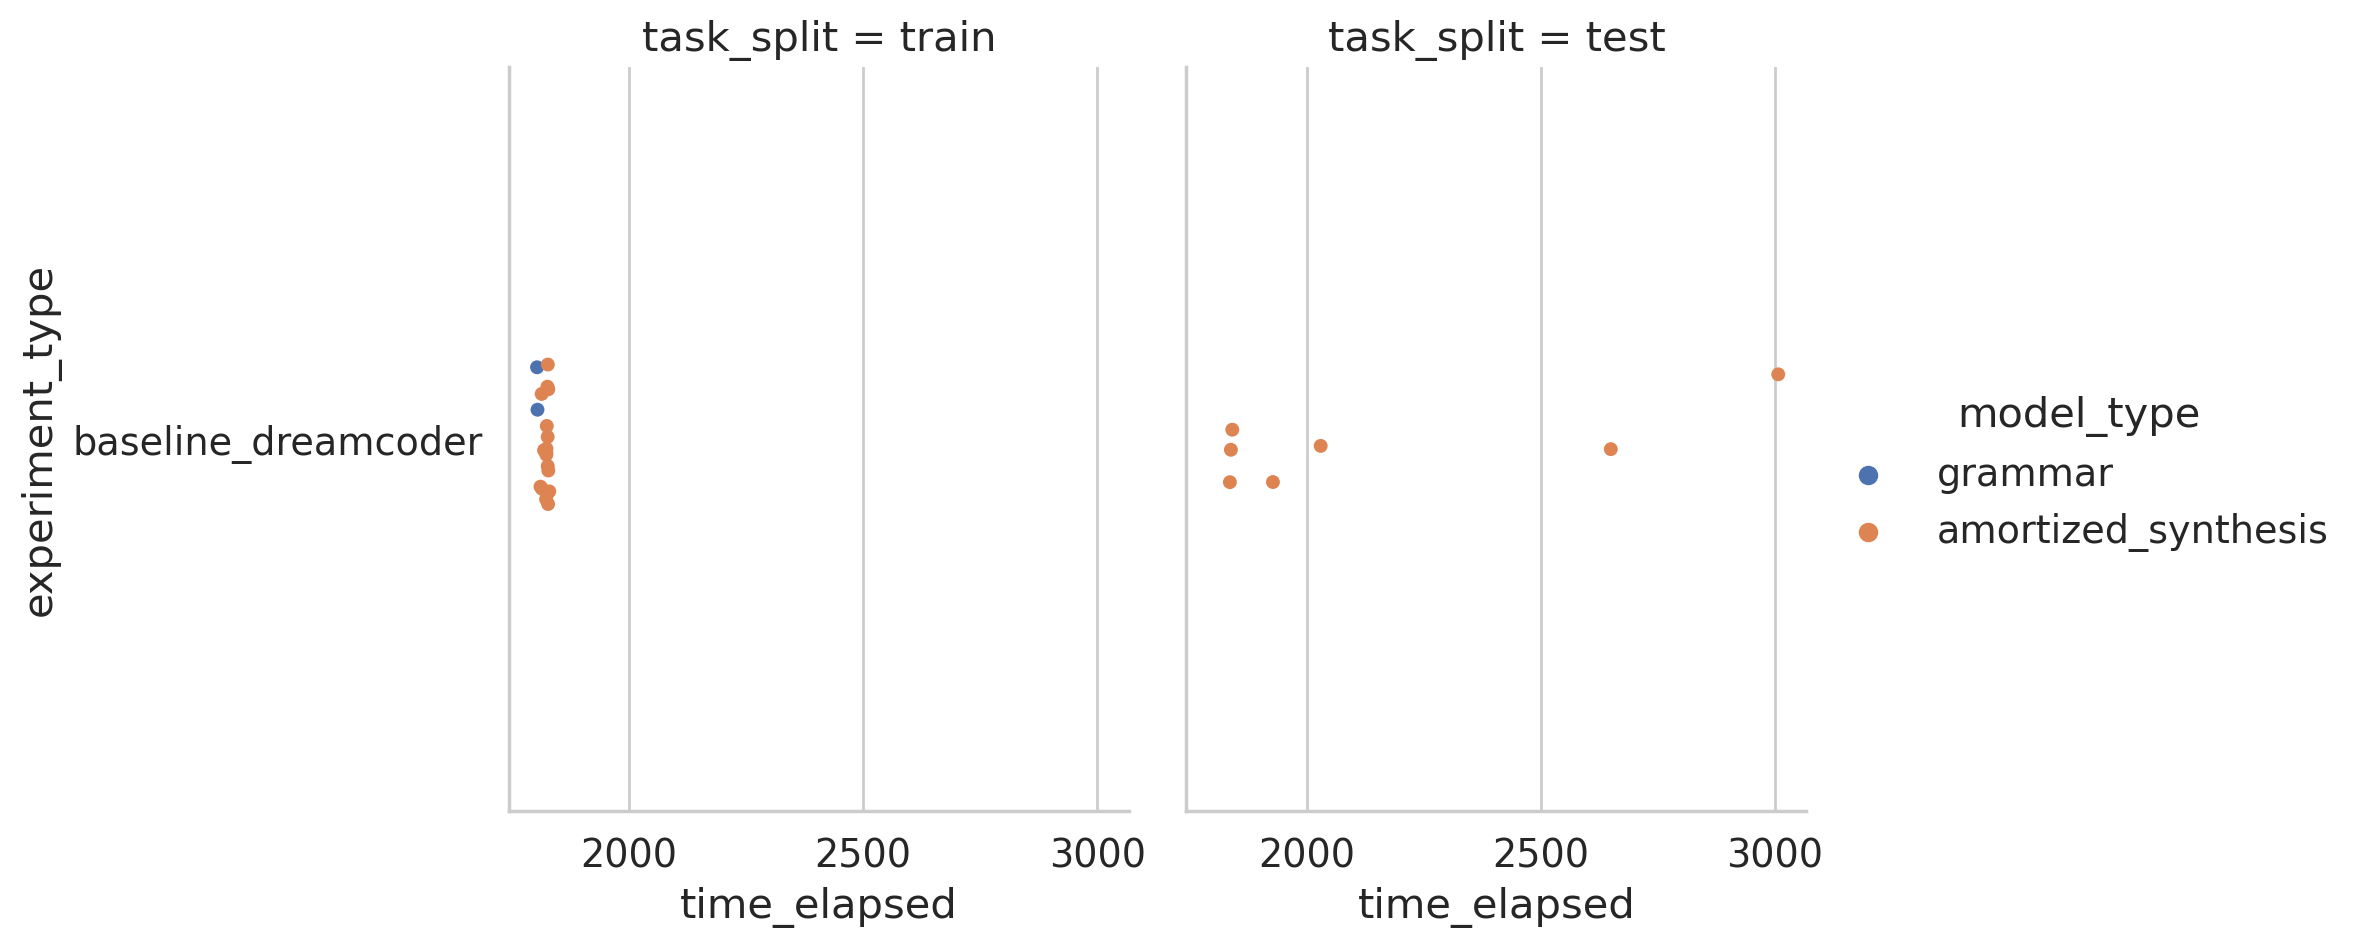

In [64]:
sns.catplot(kind="strip", col="task_split", data=df_runtime.query("model_fn == 'infer_programs_for_tasks'"), y="experiment_type", x="time_elapsed", hue="model_type")

# Analysis 1: Tasks solved over time

### Tasks solved vs. LAPS iteration

In [65]:
df_results = analyzer.get_synthesis_summary()
df_results

,domain,experiment_type,seed,iteration,split,n_solved,percent_solved
0,logo,baseline_dreamcoder,111,0,test,3,0.027027
1,logo,baseline_dreamcoder,111,0,train,18,0.090000
2,logo,baseline_dreamcoder,111,1,train,47,0.235000
3,logo,baseline_dreamcoder,111,2,train,65,0.325000
4,logo,baseline_dreamcoder,111,3,test,22,0.198198
5,logo,baseline_dreamcoder,111,3,train,71,0.355000
6,logo,baseline_dreamcoder,111,4,train,80,0.400000
7,logo,baseline_dreamcoder,111,5,train,88,0.440000
8,logo,baseline_dreamcoder,111,6,test,40,0.360360
9,logo,baseline_dreamcoder,111,6,train,93,0.465000


Text(0.5, 1.025, 'logo')

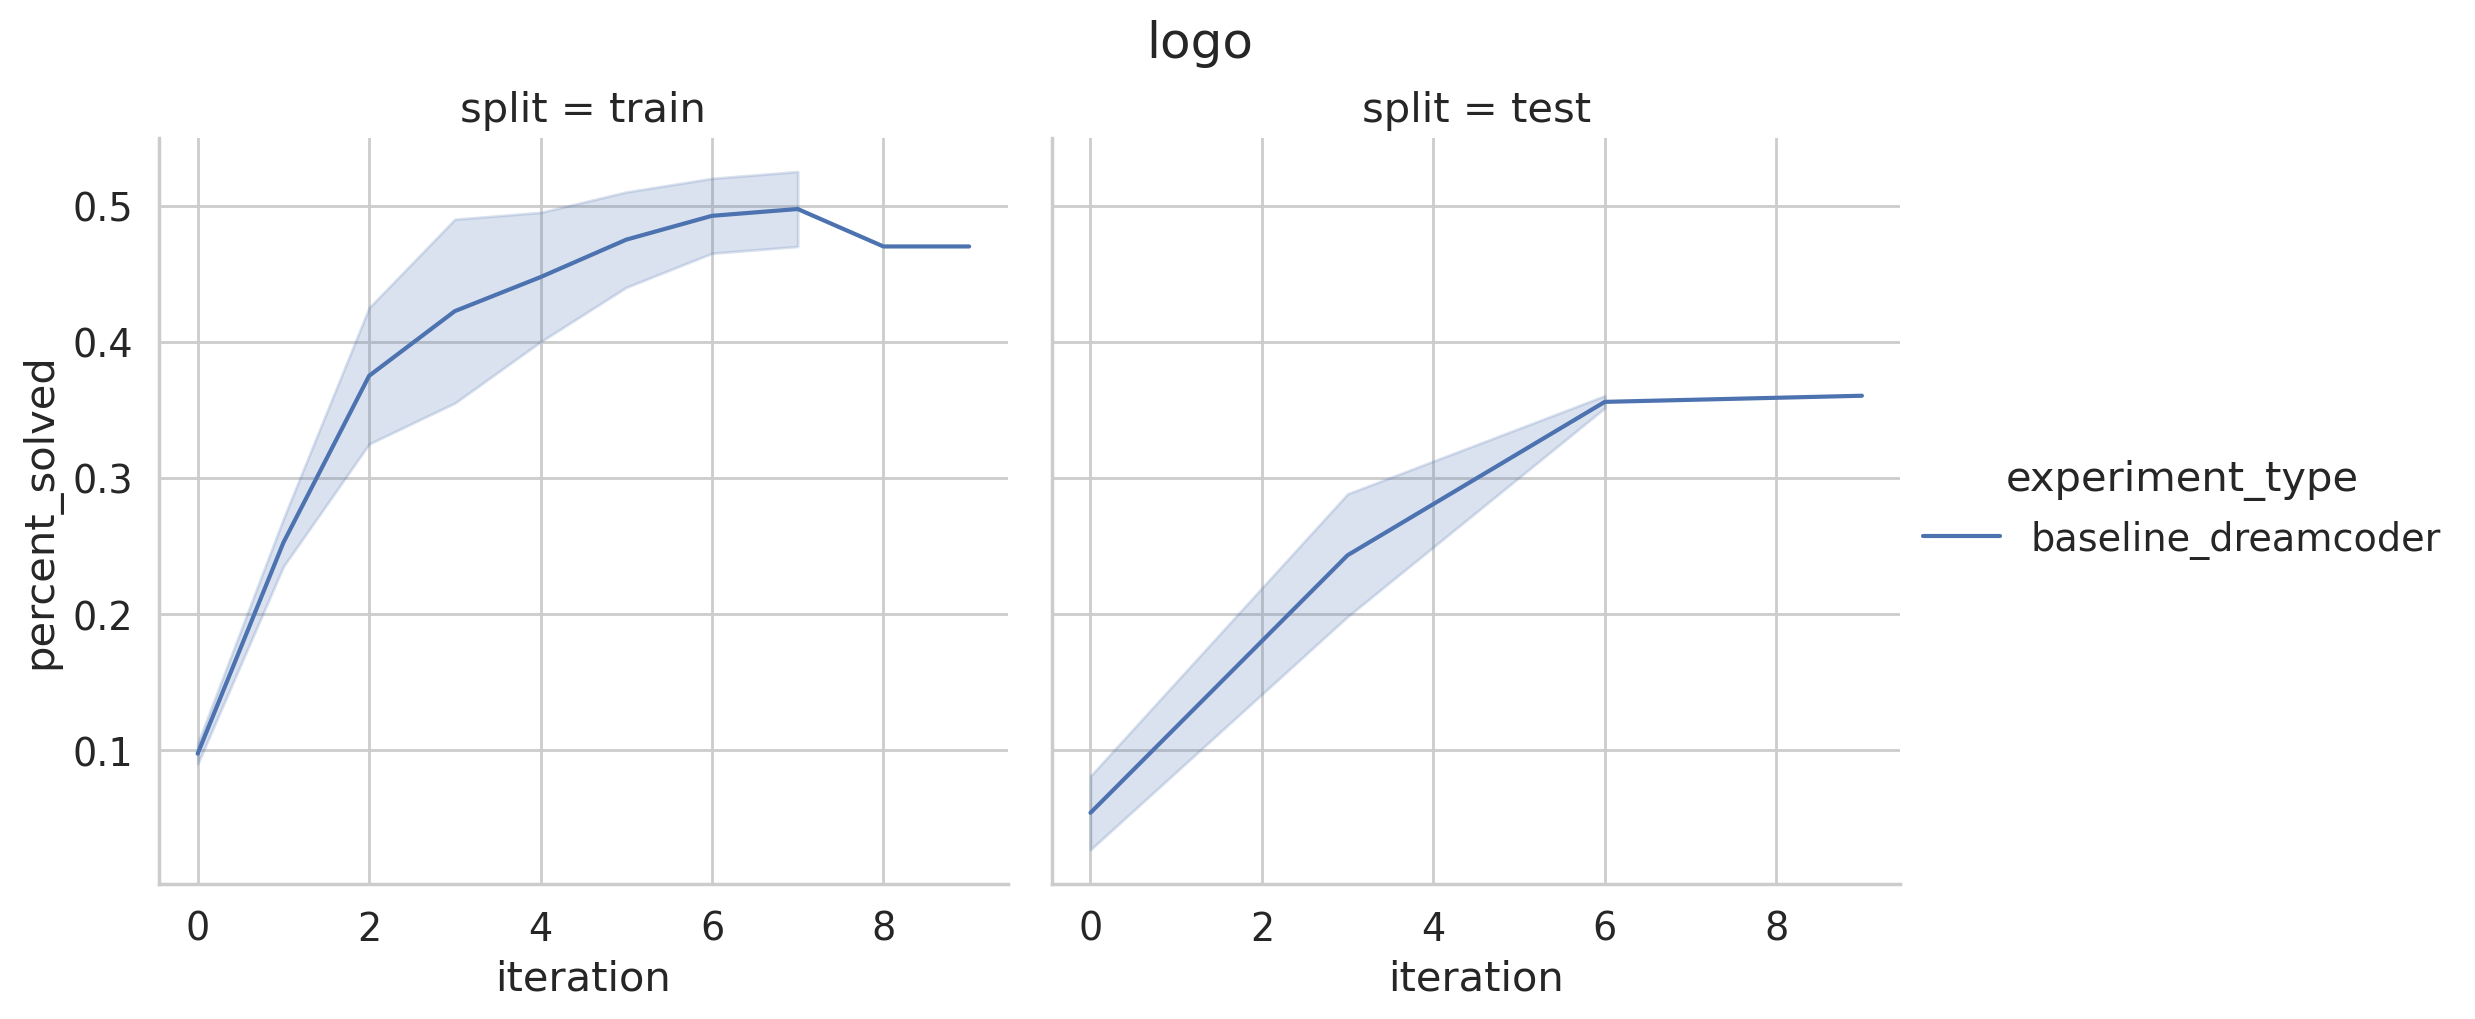

In [66]:
sns.relplot(
    data=df_results,
    kind="line",
    col="split",
    x="iteration", 
    y="percent_solved", 
    hue="experiment_type",
    # style="seed",
    markers=True,
    # errorbar="se",
    col_order=["train", "test"],
)
plt.suptitle(f"{DOMAIN}", y=1.025)

Text(0.5, 1.025, 'logo')

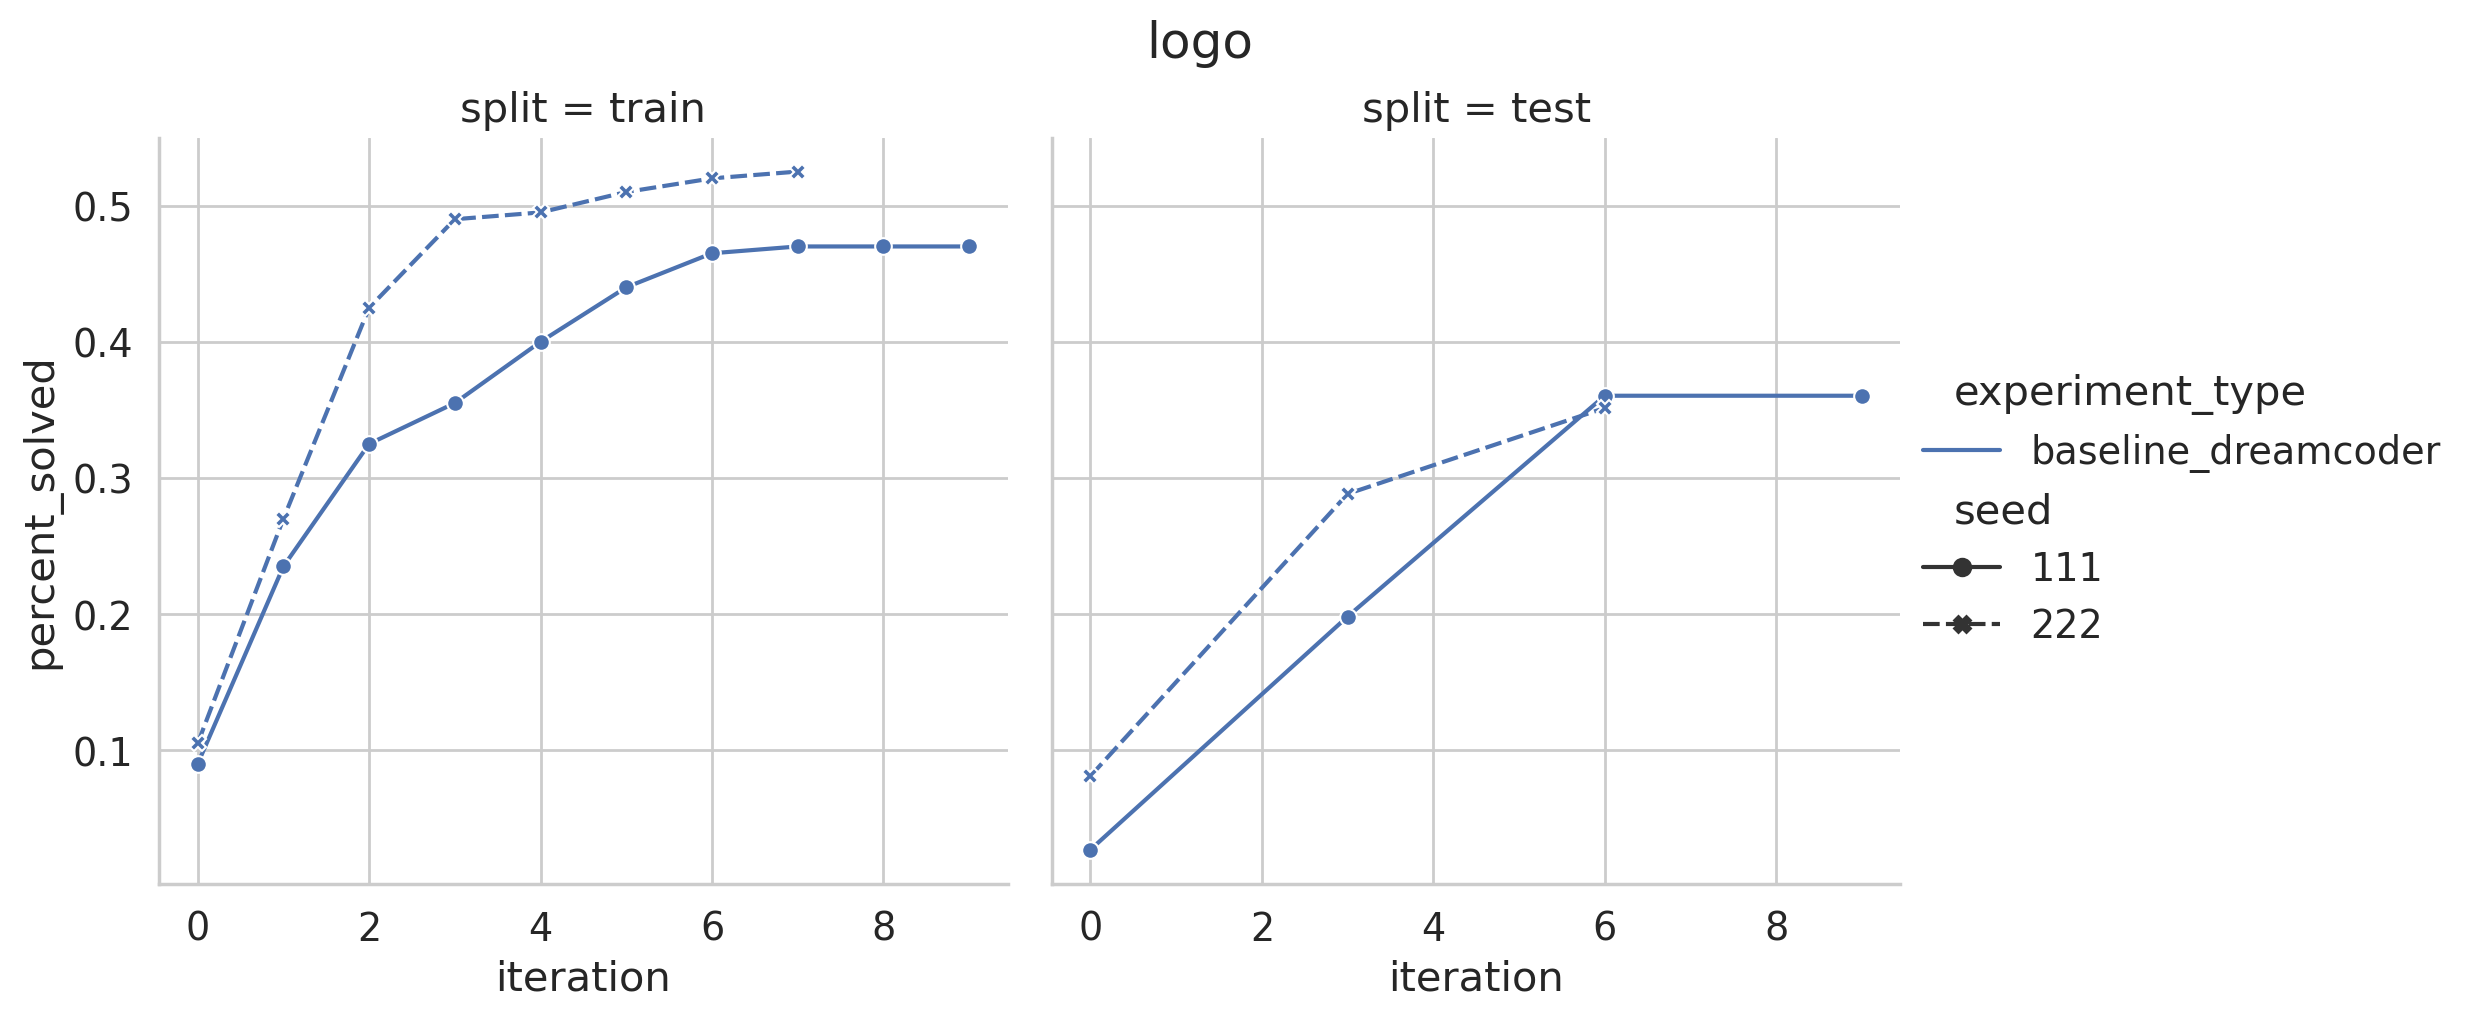

In [67]:
sns.relplot(
    data=df_results,
    kind="line",
    col="split",
    x="iteration", 
    y="percent_solved",
    hue="experiment_type",
    style="seed",
    markers=True,
    # errorbar="se",
    col_order=["train", "test"],
)
plt.suptitle(f"{DOMAIN}", y=1.025)

### Tasks solved vs. search time

In [28]:
df_search_time = analyzer.get_search_time_results_for_domain(DOMAIN)
df_search_time

TypeError: get_synthesis_results_for_domain() takes 2 positional arguments but 3 were given

In [ ]:
g = sns.lineplot(
    data=df_search_time[df_search_time.split == "train"],
    x="time",
    y="n_solved",
    # hue="seed",
    hue="iteration",
    size="iteration",
    legend="full",
    errorbar="se",
)
g.set(xscale='symlog')
plt.title(f"{DOMAIN} (train)")

In [ ]:
g = sns.relplot(
    data=df_search_time[df_search_time.split == "train"],
    col="experiment_type",
    x="time",
    y="n_solved",
    hue="iteration",
    size="iteration",
    legend="full",
    kind="line",
    errorbar="se",
)
g.set(xscale='symlog')
plt.suptitle(f"{DOMAIN} (train)")

In [ ]:
g = sns.lineplot(
    data=df_search_time[df_search_time.split == "test"],
    x="time",
    y="n_solved",
    # hue="seed",
    hue="iteration",
    size="iteration",
    legend="full",
    errorbar="se",
)
g.set(xscale='symlog')
plt.title(f"{DOMAIN} (test)")

In [ ]:
g = sns.relplot(
    data=df_search_time[df_search_time.split == "test"],
    col="experiment_type",
    x="time",
    y="n_solved",
    hue="iteration",
    size="iteration",
    legend="full",
    kind="line",
    errorbar="se",
)
g.set(xscale='symlog')
plt.suptitle(f"{DOMAIN} (test)")

# Analysis 2: Library abstractions

In [ ]:
df_abstractions = analyzer.get_abstractions_for_domain(DOMAIN)
df_abstractions.to_csv(f"{DOMAIN}_abstractions.csv", index=False)
df_abstractions

In [ ]:
ax = sns.relplot(data=df_abstractions.query("random_seed == 111").sort_values(by=["dreamcoder"], key=lambda x: x.str.len()), kind="line", col="experiment_type", y="dreamcoder", x="iteration", hue="name", size="name")
ax.set(yticklabels=[])
plt.show()

In [ ]:
with pd.option_context('display.max_colwidth', None, 'display.max_rows', None):
    display(df_abstractions.sort_values(["experiment_type", "random_seed", "name", "iteration"])[["experiment_type", "random_seed", "name", "iteration", "arity", "compression_ratio", "dreamcoder"]])

In [ ]:
sns.lineplot(data=df_abstractions, x="name", y="compression_ratio", size="iteration")

In [ ]:
sns.lineplot(data=df_abstractions, x="name", y="cumulative_compression_ratio", size="iteration", hue="iteration")
plt.title(f"{DOMAIN} compressivity of library")

In [ ]:
sns.relplot(data=df_abstractions, kind="line", errorbar="se", col="experiment_type", x="name", y="cumulative_compression_ratio", size="iteration", hue="iteration")
plt.suptitle(f"{DOMAIN} compressivity of library")

# Analysis 3: Solved programs

In [29]:
df = analyzer.get_synthesis_results_for_domain(DOMAIN)
df.to_csv(f"{DOMAIN}_search_results.csv")

# re2-specific analysis

In [30]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def task_order(keys):
    return [int(re.split(r'(\d+)', k[len("re2_test_"):])[1]) for k in keys]

def alpha_order(keys):
    return [re.split(r'(\d+)', k[len("re2_test_"):])[-1] for k in keys]

In [31]:
ITERATION = 6
SEED = 111

df_solved = df.copy()
df_solved = df_solved.query("split == 'test'").query(f"iteration == {ITERATION}").query(f"seed == {SEED}")
df_solved = df_solved[["task", "experiment_type", "solved"]]
df_solved.groupby("experiment_type").sum()

,solved
experiment_type,
baseline_dreamcoder,219
gpt_solver,332
gpt_solver_stitch_namer,288


In [32]:
df_solved

,task,experiment_type,solved
4437,re2_test_0_if_the_word_ends_with_s_replace_tha...,baseline_dreamcoder,True
4438,re2_test_1_if_there_is_any_letter_t_double_that,baseline_dreamcoder,False
4439,re2_test_2_if_the_word_starts_with_any_letter_...,baseline_dreamcoder,False
4440,re2_test_3_if_there_is_consonant_vowel_add_f_b...,baseline_dreamcoder,False
4441,re2_test_4_if_the_word_starts_with_any_letter_...,baseline_dreamcoder,True
...,...,...,...
70068,re2_test_495_if_there_is_vowel_n_replace_that_...,gpt_solver_stitch_namer,False
70069,re2_test_496_if_the_word_ends_with_any_letter_...,gpt_solver_stitch_namer,True
70070,re2_test_497_if_the_word_starts_with_any_lette...,gpt_solver_stitch_namer,True
70071,re2_test_498_if_there_is_vowel_r_add_u_before_...,gpt_solver_stitch_namer,False


In [33]:
df_solved_sorted = df_solved[["task", "experiment_type", "solved"]].pivot(index="task", columns=["experiment_type"])
df_solved_sorted = df_solved_sorted.sort_values(by="task", key=task_order)

In [34]:
def set_color(val):
    return f"color: {'green' if val else 'red'}"

with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    df_display = df_solved_sorted.reset_index(level=0)
    df_display = df_display.style.set_properties(**{'text-align': 'left'}).applymap(set_color)
    display(df_display)

In [47]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    df_display = df_solved_sorted.reset_index(level=0)
    df_display = df_display[df_display["solved"]["gpt_solver"] & ~df_display["solved"]["gpt_solver_stitch_namer"]]
    df_display = df_display.style.set_properties(**{'text-align': 'left'}).applymap(set_color)
    display(df_display)

In [43]:
df_comp["solved"]["gpt_solver"] & df_comp["solved"]["gpt_solver_stitch_namer"]

0       True
1      False
2      False
3      False
4       True
       ...  
495    False
496     True
497     True
498    False
499     True
Length: 500, dtype: bool

In [ ]:
df_vowel = df[df.task.str.contains("vowel")]
df_vowel = df_vowel.query("experiment_type == 'gpt_solver'").query(f"seed == {SEED}").query(f"iteration == {ITERATION}").query("solved")
df_vowel = df_vowel.sort_values(by="task", key=task_order)

In [ ]:
df_vowel.groupby("split").task.nunique()

In [ ]:
for _, row in df_vowel.iterrows():
    print(row.task)
    for p_data in row.programs:
        print(p_data["program"])
    print()